# Transformer

Transformer is a state-of-the-art model for Natural Language Processing. Unlike LSTM models transformers do not require recurrent connections, which is why they can be faster to train at scale. Transformers are made of stacks of transformed blocks. Each of these blocks consists of a multilayer network of simple linear layers, feedforward networks and self-attention layers. The latter of which is considered the key innovation of the transformers; self-attention layers allow for the extraction and usage of information from large contexts without the need to pass it through intermediary recurrent layers <a href="#ref">(Jurasky et al)</a>.

Importing the relevant libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import losses, optimizers
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split


## 0. Downloading the Data

In [3]:
df_train = pd.read_csv("ATML2023_reviews_train.csv")

In [4]:
df_test = pd.read_csv("ATML2023_reviews_test.csv")

In [5]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (164000, 8)
Test: (41000, 7)


There are a total of 164000 rows and 8 columns in the train set . There are a total of 41000 rows and 7 columns (excluding the response) in the test set.

## 1. Data Preprocessing

The `'review_title'` and `'review_body'` are combined together. The model performs better when the two columns are combined. NA's and duplicates are dropped and the index is reset in the train set. 

In [6]:
df_train['review_body'] = df_train['review_title'] + ' ' + df_train['review_body']
df_train = df_train.dropna().drop_duplicates().reset_index(drop=True)
df_train['review_body'] = df_train['review_body'].apply(lambda x: x.lower())

Capital letters are lowered in both data sets.

In [7]:
df_test['review_body'] = df_test['review_title'] + ' ' + df_test['review_body']
df_test['review_body'] = df_test['review_body'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [8]:
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Train: (163975, 8)
Test: (41000, 7)


The resulting shapes are 163975 rows and 8 columns in the train set and a total of 41000 rows and 7 columns (excluding the response) in the test set. 

## 3. Getting text data

Rearranging the data for training.

In [9]:
text_data = df_train[['review_body', 'rating']]
text_data_test=df_test['review_body'] 

##  4. Splitting the data


The training data set is split into test and training sets, to be able to evaluate the model.

In [10]:
# Split the data into train and test sets
X_train,X_test,Y_train, Y_test = train_test_split(text_data['review_body'], text_data['rating'],test_size=0.2, random_state=977,shuffle=True)

# Print the shapes of the train and test sets
print("Train X set shape:", X_train.shape)
print("Test X set shape:", X_test.shape)
print("Train Y set shape:", Y_train.shape)
print("Test Y set shape:", Y_test.shape)

Train X set shape: (131180,)
Test X set shape: (32795,)
Train Y set shape: (131180,)
Test Y set shape: (32795,)


The response variables `'Y_train'` and `'Y_test'` take on 5 unique values, which are 1 through 5. Here, one is removed from each rating to make the variable take on the values 0 to 4 (consistent with python language inputs).

In [11]:
Y_train= (np.array([int(label) for label in Y_train])).astype(int) - 1
Y_test= (np.array([int(label) for label in Y_test])).astype(int) - 1

##  5. Fit models preparation

The pre-trained 'bert-base-cased' model is used as input in the model. The model is defined with the `AutoTokenizer` from Transformers and the `TFAutoModelSequenceClassification` also from Transformers. The output of this model is tensorflow. 

In [30]:
n_classes = 5

pretrained_name = "bert-base-cased" 
tokenizer = AutoTokenizer.from_pretrained(pretrained_name)
model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_name, num_labels=n_classes)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The summary of the model is presented below.

In [31]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 108,314,117
Trainable params: 108,314,117
Non-trainable params: 0
_________________________________________________________________


Since a pre-trained model is used, the transformer model should not train the first layer. This reduces the number of parameters which need training.

In [32]:
model.layers[0].trainable = False 

A dictionary is created with padding and truncation.

In [34]:
X_train_tok = dict(tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="tf"))
X_test_tok = dict(tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="tf"))

Below is an example of the tensors created.

In [40]:
X_train_tok 

{'input_ids': <tf.Tensor: shape=(131180, 512), dtype=int32, numpy=
 array([[ 101, 1363, 1363, ...,    0,    0,    0],
        [ 101, 1304, 3501, ...,    0,    0,    0],
        [ 101, 1141, 2851, ...,    0,    0,    0],
        ...,
        [ 101, 1304, 9333, ...,    0,    0,    0],
        [ 101, 1122, 1110, ...,    0,    0,    0],
        [ 101, 1198, 1508, ...,    0,    0,    0]], dtype=int32)>,
 'token_type_ids': <tf.Tensor: shape=(131180, 512), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(131180, 512), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

The Adam optimizer is used with a very slow learning rate. The `SparseCategoricalCrossentropy` is used as the loss function. The metrics is specified as accuracy.

In [41]:
model.compile(optimizer=optimizers.Adam(learning_rate=3e-5),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

The transformer model takes a very long time to run, which is why it has only been performed for 5 epochs.

In [42]:
# The fit is very long without a GPU or a cloud service
# epochs = 5
# history_ft = model.fit(X_train_tok, Y_train, validation_data=(X_test_tok, Y_test),
                      # batch_size=16, epochs=epochs)

Epoch 1/5
8199/8199 [==============================] - 41650s 5s/step - loss: 1.5136 - accuracy: 0.3422 - val_loss: 1.4662 - val_accuracy: 0.3960
Epoch 2/5
8199/8199 [==============================] - 41354s 5s/step - loss: 1.4631 - accuracy: 0.3709 - val_loss: 1.4220 - val_accuracy: 0.4108
Epoch 3/5
8199/8199 [==============================] - 41419s 5s/step - loss: 1.4290 - accuracy: 0.3852 - val_loss: 1.3926 - val_accuracy: 0.4140
Epoch 4/5
8199/8199 [==============================] - 41256s 5s/step - loss: 1.4069 - accuracy: 0.3923 - val_loss: 1.3707 - val_accuracy: 0.4174
Epoch 5/5
8199/8199 [==============================] - 41248s 5s/step - loss: 1.3894 - accuracy: 0.3999 - val_loss: 1.3526 - val_accuracy: 0.4272


The training and validation accuracy hisotry is plotted below.

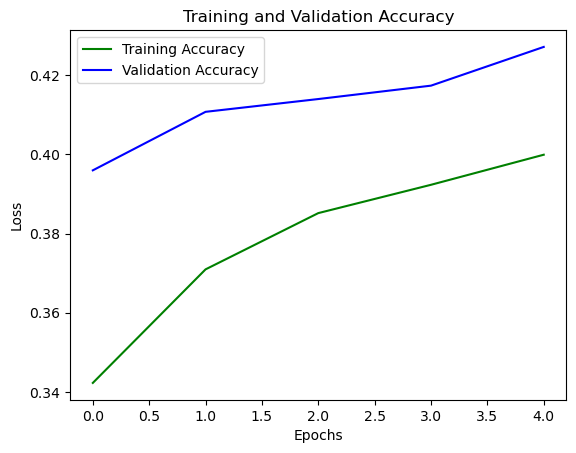

In [73]:
accuracy_train = history_ft.history['accuracy'] # ['accuracy', 'loss', 'val_accuracy', 'val_loss']
accuracy_val = history_ft.history['val_accuracy']
epochs = range(0,5)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The plot clearly depicts that the model is improving both the training and validation accuracy with every epoch. Learning is very slow and it looks like significantly more epochs are required to acheive good performance. Further training is not performed due to limits in computational power. 

In [49]:
model.load_weights("./Modelfit/Transformer")

In [51]:
_,accuracyTransformer= model.evaluate(X_test_tok,Y_test)

1025/1025 [==============================] - 7385s 7s/step - loss: 1.3526 - accuracy: 0.4272


The accuracy on the test set after 5 epochs is only 0.4274.

<h2 id="ref">References</h2>

1. Jurafsky, D., James H. M. (2023). Speech and Language Processing (3rd ed. draft), available <a href="https://web.stanford.edu/